In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from nb_004b import *
import torchvision.models as tvm

# Dogs and cats

## Basic data aug

In [ ]:
PATH = Path('data/dogscats')

train_ds = ImageDataset.from_folder(PATH/'train')
valid_ds = ImageDataset.from_folder(PATH/'valid')

arch = tvm.resnet34

In [ ]:
#export
def uniform_int(low, high, size=None):
    return random.randint(low,high) if size is None else torch.randint(low,high,size)

@TfmPixel
def dihedral(x, k:partial(uniform_int,0,8)):
    flips=[]
    if k&1: flips.append(1)
    if k&2: flips.append(2)
    if flips: x = torch.flip(x,flips)
    if k&4: x = x.transpose(1,2)
    return x.contiguous()

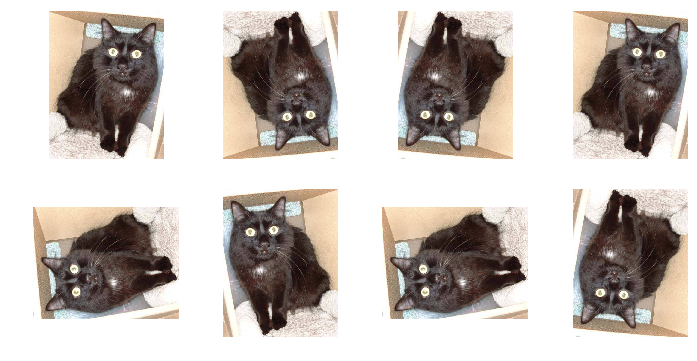

In [ ]:
x=valid_ds[2][0]
_,axes = plt.subplots(2,4, figsize=(12,6))
for i,ax in enumerate(axes.flat): dihedral(x,i).show(ax)

In [ ]:
#export
def get_transforms(do_flip=False, flip_vert=False, max_rotate=0., max_zoom=1., max_lighting=0., max_warp=0.,
                   p_affine=0.75, p_lighting=0.5, xtra_tfms=None):
    res = [rand_crop()]
    if do_flip:    res.append(dihedral() if flip_vert else flip_lr(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if max_zoom>1: res.append(rand_zoom(scale=(1.,max_zoom), p=p_affine))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad()])  

def transform_datasets(train_ds, valid_ds, tfms, **kwargs):
    return (DatasetTfm(train_ds, tfms[0], **kwargs),
            DatasetTfm(valid_ds, tfms[1], **kwargs),
            DatasetTfm(valid_ds, tfms[0], **kwargs))

imagenet_stats = tensor([0.485, 0.456, 0.406]), tensor([0.229, 0.224, 0.225])

In [ ]:
data_norm,data_denorm = normalize_funcs(*imagenet_stats)

In [ ]:
#export
class DataBunch():
    def __init__(self, train_dl:DataLoader, valid_dl:DataLoader, augm_dl:DataLoader=None,
                 device:torch.device=None, tfms=None):
        self.device = default_device if device is None else device
        self.train_dl = DeviceDataLoader(train_dl, self.device, tfms=tfms)
        self.valid_dl = DeviceDataLoader(valid_dl, self.device, tfms=tfms)
        if augm_dl: self.augm_dl = DeviceDataLoader(augm_dl,  self.device, tfms=tfms)

    @classmethod
    def create(cls, train_ds, valid_ds, augm_ds=None, bs=64, train_tfm=None, valid_tfm=None, num_workers=4,
               tfms=None, device=None, **kwargs):
        if train_tfm or not isinstance(train_ds, DatasetTfm): train_ds = DatasetTfm(train_ds,train_tfm, **kwargs)
        if valid_tfm or not isinstance(valid_ds, DatasetTfm): valid_ds = DatasetTfm(valid_ds,valid_tfm, **kwargs)
        if not augm_ds: augm_ds = DatasetTfm(valid_ds, train_tfm, **kwargs)
        return cls(DataLoader(train_ds, bs,   shuffle=True,  num_workers=num_workers),
                   DataLoader(valid_ds, bs*2, shuffle=False, num_workers=num_workers),
                   DataLoader(augm_ds,  bs*2, shuffle=False, num_workers=num_workers),
                   device=device, tfms=tfms)

    @property
    def train_ds(self): return self.train_dl.dl.dataset
    @property
    def valid_ds(self): return self.valid_dl.dl.dataset
    @property
    def c(self): return self.train_ds.c

In [ ]:
size=224

tfms = get_transforms(do_flip=True, max_rotate=10, max_zoom=1.2, max_lighting=0.3, max_warp=0.15)
tds = transform_datasets(train_ds, valid_ds, tfms, size=size)
data = DataBunch.create(*tds, bs=64, num_workers=8, tfms=data_norm)

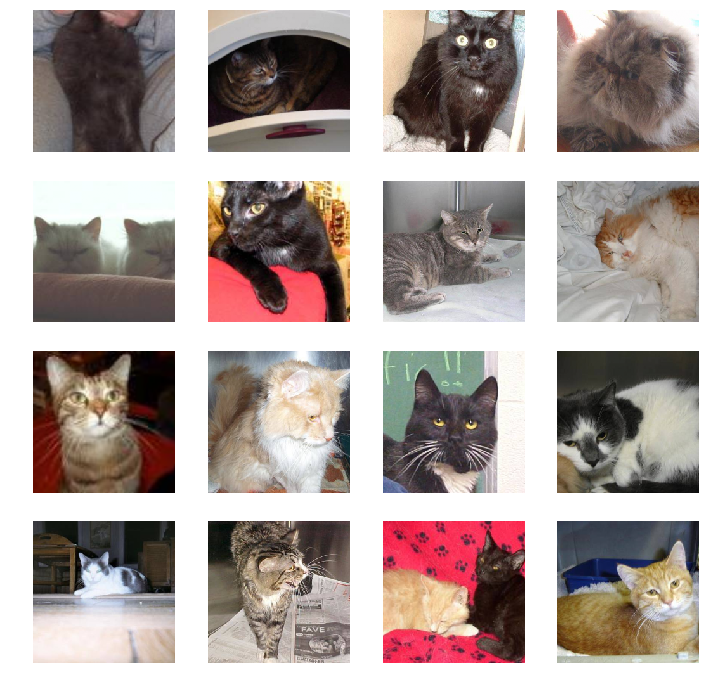

In [ ]:
(x,y) = next(iter(data.valid_dl))

_,axs = plt.subplots(4,4,figsize=(12,12))
for i,ax in enumerate(axs.flatten()): show_image(data_denorm(x[i].cpu()), ax)

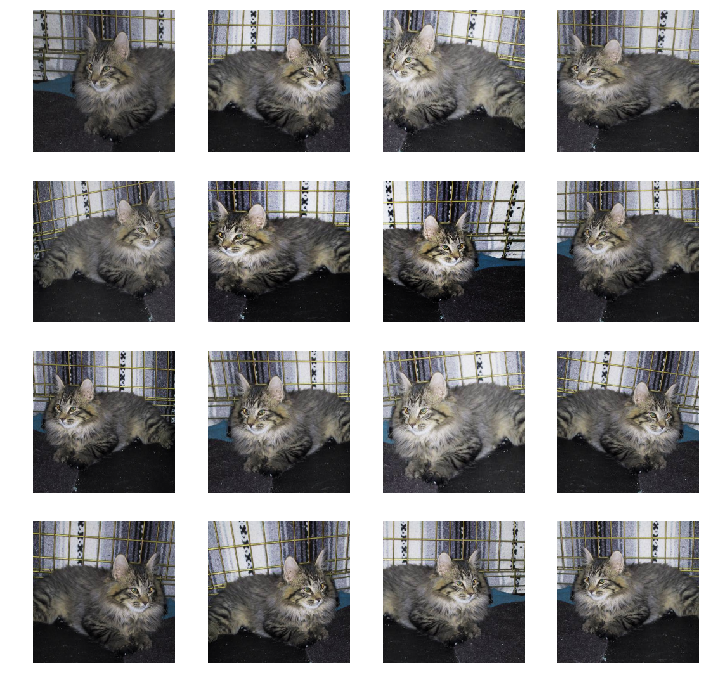

In [ ]:
_,axs = plt.subplots(4,4,figsize=(12,12))
for ax in axs.flat: tds[0][2][0].show(ax)

## ConvLearner

In [ ]:
#export
def train_epoch(model, dl, opt, loss_func):
    "Simple training of `model` for 1 epoch of `dl` using optim `opt` and loss function `loss_func`"
    model.train()
    for xb,yb in dl:
        loss = loss_func(model(xb), yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
#export
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or 1
        self.ap,self.mp = nn.AdaptiveAvgPool2d(sz), nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

def create_body(model, cut=None, body_fn=None):
    return (nn.Sequential(*list(model.children())[:-cut]) if cut
            else body_fn(model) if body_fn else model)

def num_features(m):
    for l in reversed(flatten_model(m)):
        if hasattr(l, 'num_features'): return l.num_features

In [ ]:
model = create_body(arch(), 2)
num_features(model)

512

In [ ]:
#export
def bn_drop_lin(n_in, n_out, bn=True, p=0., actn=None):
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def create_head(nf, nc, lin_ftrs=None, ps=0.2):
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns): 
        layers += bn_drop_lin(ni,no,True,p,actn)
    return nn.Sequential(*layers)

In [ ]:
create_head(512, 2)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.1)
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.2)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
#export
def cond_init(m, init_fn):
    if not isinstance(m, bn_types):
        if hasattr(m, 'weight'): init_fn(m.weight)
        if hasattr(m, 'bias') and hasattr(m.bias, 'data'): m.bias.data.fill_(0.)
            
def apply_init(m, init_fn):
    m.apply(lambda x: cond_init(x, init_fn))    

def _set_mom(m, mom):
    if isinstance(m, bn_types): m.momentum=mom

def set_mom(m, mom): m.apply(lambda x: _set_mom(x, mom))

class ConvLearner(Learner):
    def __init__(self, data, arch, cut, pretrained=True, lin_ftrs=None, ps=0.2, custom_head=None, **kwargs):
        body = create_body(arch(pretrained), cut)
        nf = num_features(body) * 2
        head = custom_head or create_head(nf, data.c, lin_ftrs, ps)
        model = nn.Sequential(body, head)
        super().__init__(data, model, **kwargs)
        self.split([model[1]])
        if pretrained: self.freeze()
        apply_init(model[1], nn.init.kaiming_normal_)

In [ ]:
lr = 3e-3

## Train

In [ ]:
learn = ConvLearner(data, arch, 2, wd=1e-2, metrics=accuracy, ps=[0.1,0.2])

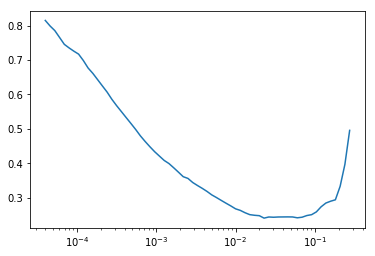

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, slice(lr))

In [ ]:
learn.fit_one_cycle(3, slice(lr))

Total time: 03:07
epoch  train loss  valid loss  accuracy
0      0.060433    0.030682    0.987500  (01:01)
1      0.049539    0.025571    0.992500  (01:02)
2      0.026817    0.020059    0.993000  (01:03)



In [ ]:
learn.save('0')

## Unfreeze

In [ ]:
learn.load('0')

In [ ]:
learn.unfreeze()

In [ ]:
lr=6e-4

In [ ]:
learn.fit_one_cycle(6, slice(lr/25,lr), pct_start=0.05)

Total time: 09:16
epoch  train loss  valid loss  accuracy
0      0.031794    0.022519    0.991500  (01:24)
1      0.025178    0.023334    0.989000  (01:26)
2      0.014190    0.015775    0.995500  (01:27)
3      0.009726    0.012706    0.995000  (02:04)
4      0.008272    0.012108    0.994500  (01:27)
5      0.006339    0.012217    0.995500  (01:27)



In [ ]:
learn.save('1')

In [ ]:
learn.load('1')

## Save activations

In [ ]:
#export
class HookCallback(LearnerCallback):
    def __init__(self, learn, modules=None, do_remove=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove
        self.hooks = []

    def on_train_begin(self, **kwargs):
        self.hooks = []
        modules = self.modules
        if not modules:
            modules = [m for m in flatten_model(self.learn.model)
                       if hasattr(m, 'weight')]
        for module in modules:
            func = self.hook(module)
            self.hooks.append(module.register_forward_hook(func))

    def remove(self):
        for hook in self.hooks: hook.remove()
        self.hooks=[]

    def on_train_end(self, **kwargs):
        if self.do_remove: self.remove()

    def __del__(self): self.remove()

In [ ]:
#export
class ActivationsCallback(HookCallback):
    def hook(self, module):
        def _hook(m,i,o): self.outputs[module]=o.detach()
        return _hook

    def on_train_begin(self, **kwargs):
        super().on_train_begin(**kwargs)
        self.outputs = {}

class ActivationStats(ActivationsCallback):
    def on_train_begin(self, **kwargs):
        super().on_train_begin(**kwargs)
        self.means,self.stds = [],[]
        
    def on_batch_end(self, **kwargs):
        means,stds = zip(*[(value.mean().item(),value.std().item())
                           for key, value in self.outputs.items()])
        self.means.append(means)
        self.stds.append (stds )
        
    def on_train_end(self, **kwargs):
        means,stds = {},{}
        for (i,(k,v)) in enumerate(self.outputs.items()):
            means[k] = [o[i] for o in self.means]
            stds[k]  = [o[i] for o in self.stds ]
        self.means,self.stds = means,stds

In [ ]:
learn = ConvLearner(data, arch, 2, wd=1e-2, metrics=accuracy,
                    callback_fns=ActivationStats)

In [ ]:
learn.fit_one_cycle(1, lr)

Total time: 01:12
epoch  train loss  valid loss  accuracy
0      0.048640    0.025829    0.987500  (01:12)



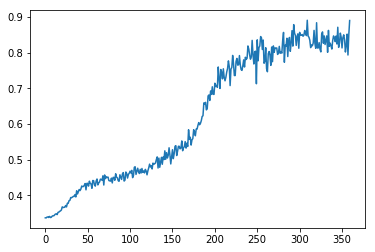

In [ ]:
l=learn.model[-1][4]
plt.plot(learn.activation_stats.means[l]);

## TTA

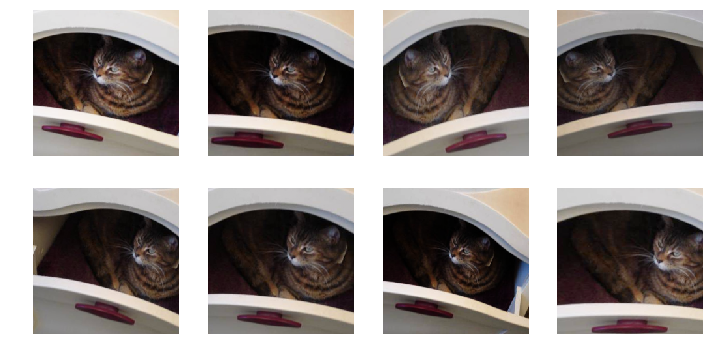

In [ ]:
_,axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flat: tds[2][1][0].show(ax)

In [ ]:
model = learn.model

In [ ]:
def get_preds(model, dl, pbar=None):
    return [torch.cat(o).cpu() for o in validate(model, dl, pbar=pbar)]

In [ ]:
preds,y = get_preds(model, data.valid_dl)

In [ ]:
accuracy(preds, y)

tensor(0.9955)

In [ ]:
pbar = master_bar(range(4))
all_preds = torch.stack([get_preds(model, data.augm_dl, pbar=pbar)[0] for _ in pbar])

Total time: 00:18



In [ ]:
avg_preds = all_preds.mean(0)
avg_preds.shape

torch.Size([2000, 2])

In [ ]:
accuracy(avg_preds, y)

tensor(0.9945)

In [ ]:
beta=0.5
accuracy(preds*beta + avg_preds*(1-beta), y)

tensor(0.9955)

## Fin